In [1]:
import numpy as np
import torch
import pandas as pd
import importlib
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

import utils_roughvol
import deep_sets

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (7, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

We assume that prices follow the following fractional OU process

$$dX_t =  -\alpha(X_t - \mu) + \nu dW^H_t$$

where $W^H_t$ is fBM with H<0.5. This RDE has an explicit solution

$$X_t = \nu \int_{-\infty}^t e^{-\alpha(t-s)}dW_s^H + \mu$$

The Rough Fractional Stochastic Volatility (RFSV) model is defined in https://arxiv.org/pdf/1410.3394.pdf as follows

$$\sigma_t = e^{X_t}$$

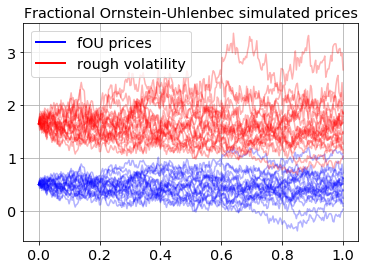

In [3]:
tot = 20
l = 300
df = pd.DataFrame(data=[utils_roughvol.fOU_generator(k*1e-4,length=l) for k in range(1,tot)], columns=np.linspace(0,1,l+1),
                  index=['alpha = {:.1f} x 10^-4'.format(k) for k in range(1,tot)]).T
df_vol = df.apply(lambda x: np.exp(x))


custom_lines = [Line2D([0], [0], color='blue', lw=2), Line2D([0], [0], color='red', lw=2)]
fig, ax = plt.subplots()
df.plot(grid=True, title='Fractional Ornstein-Uhlenbec simulated prices',legend=False,c='blue',alpha=0.3, ax=ax)
df_vol.plot(grid=True, legend=False,c='red',alpha=0.3,ax=ax)
ax.legend(custom_lines, ['fOU prices', 'rough volatility'])
plt.show()

# Set up learning parameters

In [4]:
n_bags = 100
n_items = 10

mus = np.linspace(1e-6, 1e0, n_bags)

# Poly-SVM

In [21]:
for deg in [1,2,3]:
    print(utils_roughvol.poly_SVM(deg, mus, n_bags, n_items, tuned_parameters))


Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed:    3.2s finished


(0.08767367680027975, 0.06652775543378855)



Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed:   15.5s finished


(0.08595184221880599, 0.06278172767906809)



Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed:  7.3min finished


(0.10240236217517625, 0.07823693858797166)


# ESig-SVM

In [19]:
for dep in [2,3,4]:
    print(utils_roughvol.ESig_SVM(dep, mus, n_bags, n_items, tuned_parameters))


Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed:    0.5s finished


(0.0048412195834702495, 0.0017486071841634847)



Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed:    0.4s finished


(0.005414053154269796, 0.00394772456298771)



Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed:    0.4s finished


(0.004333335801647685, 0.001643824124352354)


# Pathwise-ESig-SVM

In [121]:
importlib.reload(utils_roughvol)

<module 'utils_roughvol' from 'C:\\Users\\Cristopher\\source\\repos\\maudl3116\\Distribution_Regression_Streams\\notebooks\\utils_roughvol.py'>

In [122]:
utils_roughvol.SigESig_SVM(2, 2, mus, n_bags, n_items)


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    2.1s finished


(0.005724567300066608, 0.0023238509722193303)

# Neural Net approach (Deep Sets) 

https://arxiv.org/pdf/1703.06114.pdf

In [28]:
# importlib.reload(deep_sets)

In [29]:
batch_size = 20
nb_epoch = 500

In [35]:
MSEs = []

for j in tqdm(range(5)):
    
    X = []
    for a in tqdm(mus):
        intermediate = []
        for n in range(n_items):
            intermediate.append(np.exp(utils_roughvol.fOU_generator(a)))
        X.append(intermediate)
        
    X_train, X_test, y_train, y_test = train_test_split(X, mus, test_size=0.2, random_state=None)
    
    train = deep_sets.DataIterator(torch.Tensor(X_train), torch.Tensor(y_train), batch_size, shuffle=True)
    test  = deep_sets.DataIterator(torch.Tensor(X_test), torch.Tensor(y_test), 1)

    model = deep_sets.DeepSet

    t = deep_sets.Trainer(train.d, model, nb_epoch)

    t.fit(train)
    
    MSEs.append(t.evaluate(test))
    
print(np.mean(MSEs), np.std(MSEs))

Train loss: 0.2346
Train loss: 0.0549
Train loss: 0.0549
Train loss: 0.0549
Train loss: 0.0549
Train loss: 0.0549
Train loss: 0.0549
Train loss: 0.0549
Train loss: 0.0548
Train loss: 0.0549


C:\Users\Cristopher\AppData\Roaming\Python\Python36\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train loss: 0.3743
Train loss: 0.0073
Train loss: 0.0071
Train loss: 0.0062
Train loss: 0.0037
Train loss: 0.0031
Train loss: 0.0022
Train loss: 0.0018
Train loss: 0.0007
Train loss: 0.0011


Train loss: 0.4746
Train loss: 0.0176
Train loss: 0.0140
Train loss: 0.0166
Train loss: 0.0148
Train loss: 0.0084
Train loss: 0.0252
Train loss: 0.0105
Train loss: 0.0065
Train loss: 0.0115


Train loss: 0.6606
Train loss: 0.0401
Train loss: 0.0228
Train loss: 0.0007
Train loss: 0.0003
Train loss: 0.0001
Train loss: 0.0010
Train loss: 0.0000
Train loss: 0.0000
Train loss: 0.0000


Train loss: 1.3938
Train loss: 0.0461
Train loss: 0.0461
Train loss: 0.0461
Train loss: 0.0461
Train loss: 0.0461
Train loss: 0.0461
Train loss: 0.0461
Train loss: 0.0461
Train loss: 0.0461
0.11309875324845053 0.04512854493550634


# Deep Set adapted to sequential data: DeepSet-RNN

In [ ]:
MSEs = []

for j in tqdm(range(5)):
    
    X = []
    for a in tqdm(mus):
        intermediate = []
        for n in range(n_items):
            intermediate.append(np.exp(utils_roughvol.fOU_generator(a)))
        X.append(intermediate)
        
    X_train, X_test, y_train, y_test = train_test_split(X, mus, test_size=0.2, random_state=None)
    
    train = deep_sets.DataIterator(torch.Tensor(X_train), torch.Tensor(y_train), batch_size, shuffle=True)
    test  = deep_sets.DataIterator(torch.Tensor(X_test), torch.Tensor(y_test), 1)

    model = deep_sets.DeepSetRNN

    t = deep_sets.Trainer(train.d, model, nb_epoch)

    t.fit(train)
    
    MSEs.append(t.evaluate(test))
    
print(np.mean(MSEs), np.std(MSEs))

Train loss: 0.0597
Train loss: 0.0620


# Deep Set adapted to sequential data: DeepSet-GRU

In [ ]:
MSEs = []

for j in tqdm(range(5)):
    
    X = []
    for a in tqdm(mus):
        intermediate = []
        for n in range(n_items):
            intermediate.append(np.exp(utils_roughvol.fOU_generator(a)))
        X.append(intermediate)
        
    X_train, X_test, y_train, y_test = train_test_split(X, mus, test_size=0.2, random_state=None)
    
    train = deep_sets.DataIterator(torch.Tensor(X_train), torch.Tensor(y_train), batch_size, shuffle=True)
    test  = deep_sets.DataIterator(torch.Tensor(X_test), torch.Tensor(y_test), 1)

    model = deep_sets.DeepSetGRU

    t = deep_sets.Trainer(train.d, model, nb_epoch)

    t.fit(train)
    
    MSEs.append(t.evaluate(test))
    
print(np.mean(MSEs), np.std(MSEs))

# Deep Set adapted to sequential data: DeepSet-LSTM

In [ ]:
MSEs = []

for j in tqdm(range(5)):
    
    X = []
    for a in tqdm(mus):
        intermediate = []
        for n in range(n_items):
            intermediate.append(np.exp(utils_roughvol.fOU_generator(a)))
        X.append(intermediate)
        
    X_train, X_test, y_train, y_test = train_test_split(X, mus, test_size=0.2, random_state=None)
    
    train = deep_sets.DataIterator(torch.Tensor(X_train), torch.Tensor(y_train), batch_size, shuffle=True)
    test  = deep_sets.DataIterator(torch.Tensor(X_test), torch.Tensor(y_test), 1)

    model = deep_sets.DeepSetLSTM

    t = deep_sets.Trainer(train.d, model, nb_epoch)

    t.fit(train)
    
    MSEs.append(t.evaluate(test))
    
print(np.mean(MSEs), np.std(MSEs))